In [1]:
from models.SegRNN.Model import Model as SegRNN
from models.DLinear.Model import Model as DLinear
from models.PatchTST.Model import Model as PatchTST
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
from utils.ModelWrapper import ModelWrapper
from utils.generate_config import get_config_for

In [2]:
pred_len = 96
datapath = 'ETTh1.csv'
config_normal = get_config_for(datapath, pred_len, training_type='normal')
config_occasional = get_config_for(datapath, pred_len, training_type='occasional', n_iter=1)
config_weighted = get_config_for(datapath, pred_len, training_type='weighted')

config_normal_patchtst = get_config_for(datapath, pred_len, training_type='normal', model='PatchTST')
config_occasional_patchtst = get_config_for(datapath, pred_len, training_type='occasional', n_iter=1, model='PatchTST')
config_weighted_patchtst = get_config_for(datapath, pred_len, training_type='weighted', model='PatchTST')

In [3]:
models = [ModelWrapper(DLinear, config_normal), ModelWrapper(SegRNN, config_normal), ModelWrapper(PatchTST, config_normal_patchtst)]
# Loads the models
for model in models:
    model.train()
    model.eval()

Loading trained model from:  ./trained_models/DLinear/ETTh1/96/normal
Loading trained model from:  ./trained_models/SegRNN/ETTh1/96/normal
Loading trained model from:  ./trained_models/PatchTST/ETTh1/96/normal


test 2785


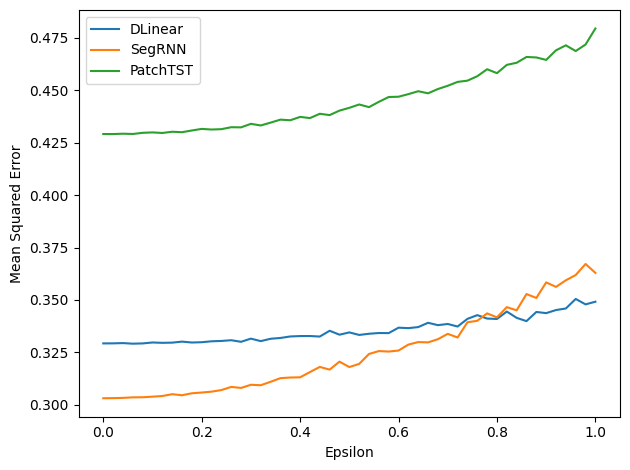

In [4]:
%matplotlib inline
epss = torch.arange(0, 1+0.02, 0.02)
config_normal.batch_size = 1
_, test_loader = models[0].get_data('test')
for (batch_x, batch_y, _, _) in test_loader:
    input_x = batch_x.float().to(models[0].config.device)
    input_y = batch_y.float()
    break
true = input_y[:, -pred_len:, :]

for model in models:
    tots = []
    for eps in epss:
        tot = 0
        for i in range(100):
            rand_input = input_x + torch.rand_like(input_x) * 2 * eps - eps
            tweaked_pred = model.forward(rand_input).detach().cpu()
            tot += ((true - tweaked_pred) ** 2).mean()
        tots.append(tot / 100)
    plt.plot(epss, tots, label=str(model))
plt.xlabel('Epsilon')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
def min_max_normalize(tensor, eps=1e-2):
    new_min = -eps
    new_max = eps

    min_val = tensor.min(dim=1, keepdim=True).values
    max_val = tensor.max(dim=1, keepdim=True).values
    
    denom = max_val - min_val
    denom[denom == 0] = 1

    normalized_tensor = ((tensor - min_val) / denom) * (new_max - new_min) + new_min
    
    return normalized_tensor

def min_max_normalize_to_bounds(tensor, eps=1e-2):
    new_min = -eps
    new_max = eps

    min_val = tensor.min(dim=1, keepdim=True)[0]
    max_val = tensor.max(dim=1, keepdim=True)[0]
    
    midpoints = (min_val + max_val) / 2

    closer_to_max = tensor > midpoints

    normalized_tensor = torch.where(closer_to_max, torch.full_like(tensor, new_max), torch.full_like(tensor, new_min))

    return normalized_tensor

def standardize(tensor, var):
    mean = tensor.mean(dim=1, keepdim=True)
    std = tensor.std(dim=1, keepdim=True)
    return ((tensor - mean) / (std)) * torch.tensor(var).sqrt()

In [6]:
def adversarial_noise(input_x, true, model_wrapper, learning_rate=0.005, verbose=True):
    """
    Performs gradient ascent to maximize the activations of a given layer.
    
    Args:
    - n_iterations: the number of iterations to perform
    - learning_rate: the learning rate of the optimizer
    - image: the image to optimize
    - model: the model to use
    - layer: the layer from which to extract the activations
    
    Returns:
    - image: the enhanced image
    """

    enhanced_input_x = input_x.clone()
    criterion  = nn.MSELoss()
    # model_wrapper.eval()
    enhanced_input_x.requires_grad = True
    # optimizer = SGD([enhanced_input_x], lr=learning_rate)
    optimizer = Adam([enhanced_input_x], lr=learning_rate)
    # model_wrapper.model.train()
    # with torch.no_grad():
    #     prev_pred = model_wrapper.forward(input_x.detach()).detach()
    for iter_count in range(500):
        optimizer.zero_grad()     
        pred = model_wrapper.forward(enhanced_input_x)
        pred = pred[:, -model_wrapper.config.pred_len:, :]
        loss = -criterion(pred, true.to(model_wrapper.config.device))
        # loss = -criterion(pred, prev_pred)
        # loss = pred[0, 0, 0]
        # loss = pred.mean()
        loss.backward()
        optimizer.step()
        # with torch.no_grad():
        #     image.grad /= torch.abs(image.grad).mean()
        #     image += learning_rate * image.grad
        if iter_count % 200 == 0 and verbose:
            diff = torch.abs(enhanced_input_x - input_x).mean()
            print(f"Iteration {iter_count}, Loss: {loss.item()} Avg Diff: {diff}")

        # with torch.no_grad():
            # diff = enhanced_input_x - input_x
            # enhanced_input_x = min_max_normalize(diff, eps) + input_x
            # enhanced_input_x = min_max_normalize_to_bounds(diff, eps) + input_x
            # enhanced_input_x = standardize(diff, eps) + input_x
    # return enhanced_input_x.detach()
    return (enhanced_input_x - input_x).detach()

In [7]:
pred_lens = [96, 192, 336, 720]
data_paths = ['ETTh1.csv', 'ETTh2.csv', 'ETTm1.csv', 'ETTm2.csv', 'electricity.csv', 'traffic.csv', 'weather.csv']
model_name = 'DLinear'
model_map = {'DLinear': DLinear, 'SegRNN': SegRNN, 'PatchTST': PatchTST}
model_class = model_map[model_name]
epss = torch.arange(0, 0.5, 0.02)
metrics = torch.zeros(len(pred_lens), len(data_paths), 3, len(epss), 2)

for pred_len in pred_lens:
    for data_path in data_paths:
        config_normal = get_config_for(data_path, pred_len, model_name, training_type='normal')
        config_occasional = get_config_for(data_path, pred_len, model_name, training_type='occasional', n_iter=1)
        config_weighted = get_config_for(data_path, pred_len, 0.5, model_name, training_type='weighted')
        configs = [config_normal, config_occasional, config_weighted]
        for config in configs:
            config.batch_size = 1
        models = [ModelWrapper(model_class, config) for config in configs]

        _, test_loader = models[0].get_data('test')
        for (batch_x, batch_y, _, _) in test_loader:
            input_x = batch_x.float().to(models[0].config.device)
            input_y = batch_y.float()
            break
        true = input_y[:, -pred_len:, :]
        tots_per_model = []
        tots_adv_per_model = []
        methods = ['Baseline', 'Occasional Robust Loss', 'Weighted Loss']
        for method, model in zip(methods, models):
            model.train()
            model.eval()
            tots = []
            tots_adv = []
            diff = adversarial_noise(input_x, true, model)
            for eps in epss:
                tot = 0
                for i in range(50):
                    rand_input_x = input_x + torch.rand_like(input_x) * 2 * eps - eps
                    tweaked_pred = model.forward(rand_input_x).detach().cpu()
                    tot += ((true - tweaked_pred) ** 2).mean()

                tweaked_pred_adv = model.forward(min_max_normalize_to_bounds(diff, eps) + input_x).detach().cpu()
                tot_adv = ((true - tweaked_pred_adv) ** 2).mean()

                tots.append(tot / 50)
                tots_adv.append(tot_adv)
            metrics[pred_lens.index(pred_len), data_paths.index(data_path), methods.index(method)] = torch.tensor([tots, tots_adv]).T

test 2785
Loading trained model from:  ./trained_models/DLinear/ETTh1/96/normal
Iteration 0, Loss: -0.32924342155456543 Avg Diff: 0.004998603370040655
Iteration 200, Loss: -3.175814628601074 Avg Diff: 1.2411243915557861
Iteration 400, Loss: -12.431265830993652 Avg Diff: 2.745255708694458
Loading trained model from:  ./trained_models/DLinear/ETTh1/96/occasional/1
Iteration 0, Loss: -0.3069162666797638 Avg Diff: 0.004996906965970993
Iteration 200, Loss: -2.7762839794158936 Avg Diff: 1.2598434686660767
Iteration 400, Loss: -10.588947296142578 Avg Diff: 2.7635178565979004
Loading trained model from:  ./trained_models/DLinear/ETTh1/96/weighted
Iteration 0, Loss: -0.294521301984787 Avg Diff: 0.004997720941901207
Iteration 200, Loss: -3.068720817565918 Avg Diff: 1.2494078874588013
Iteration 400, Loss: -12.086319923400879 Avg Diff: 2.7300777435302734
test 2785
Loading trained model from:  ./trained_models/DLinear/ETTh2/96/normal
Iteration 0, Loss: -0.12305257469415665 Avg Diff: 0.0049934638664

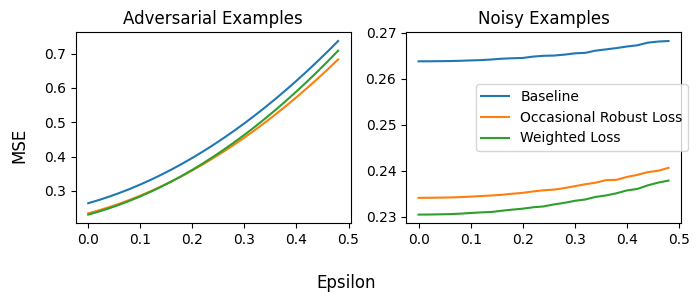

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
axs[0].plot(epss, (metrics.mean(dim=(0, 1)))[:, :, 1].T)
axs[1].plot(epss, (metrics.mean(dim=(0, 1)))[:, :, 0].T)
axs[0].title.set_text('Adversarial Examples')
axs[1].title.set_text('Noisy Examples')
fig.legend(methods, loc=(0.68, 0.5))
fig.supxlabel('Epsilon')
fig.supylabel('MSE')
plt.tight_layout()
plt.show()

Loading trained model from:  ./trained_models/DLinear/ETTh2/96/occasional/20
test 2785


Loading trained model from:  ./trained_models/DLinear/ETTh2/96/occasional/10
test 2785
Loading trained model from:  ./trained_models/DLinear/ETTh2/96/occasional/5
test 2785
Loading trained model from:  ./trained_models/DLinear/ETTh2/96/occasional/2
test 2785
Loading trained model from:  ./trained_models/DLinear/ETTh2/96/occasional/1
test 2785


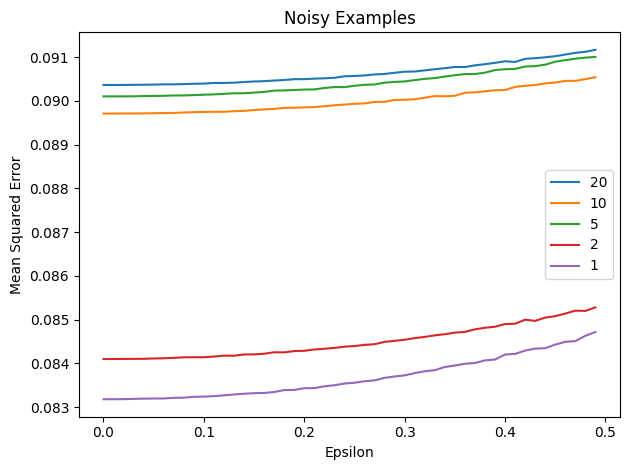

In [9]:
pred_len = 96
epss = torch.arange(0, 0.5, 0.01)
for n_iter in [20, 10, 5, 2, 1]:
    config = get_config_for('ETTh2.csv', pred_len, training_type='occasional', n_iter=n_iter)
    model = ModelWrapper(DLinear, config)
    model.train()
    model.eval()
    tots = []
    _, test_loader = model.get_data('test')
    for (batch_x, batch_y, _, _) in test_loader:
        input_x = batch_x.float().to(models[0].config.device)
        input_y = batch_y.float()
        break
    true = input_y[:, -pred_len:, :]

    for eps in epss:
        tot = 0
        for i in range(100):
            rand_input = input_x + torch.rand_like(input_x) * 2 * eps - eps
            tweaked_pred = model.forward(rand_input).detach().cpu()
            tot += ((true - tweaked_pred)**2).mean()
        tots.append(tot / 100)
    plt.plot(epss, tots, label=str(n_iter))
plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Mean Squared Error')
plt.title('Noisy Examples')
plt.tight_layout()
plt.show()

In [14]:
eps = 0.2
config = get_config_for('ETTm1.csv', pred_len, training_type='normal')
config.batch_size = 1
model_wrapper = ModelWrapper(DLinear, config)
for batch_x, batch_y, _, _ in test_loader:
    input_x = batch_x.float().to(model_wrapper.config.device)
    input_y = batch_y.float()
    break
pred = model_wrapper.forward(input_x).detach().cpu()
tweaked_input_x  = input_x + min_max_normalize_to_bounds(adversarial_noise(input_x, true, model_wrapper), eps)

Iteration 0, Loss: -0.11243295669555664 Avg Diff: 0.004680047743022442
Iteration 200, Loss: -2.471938133239746 Avg Diff: 1.4119970798492432
Iteration 400, Loss: -10.119210243225098 Avg Diff: 3.034714937210083


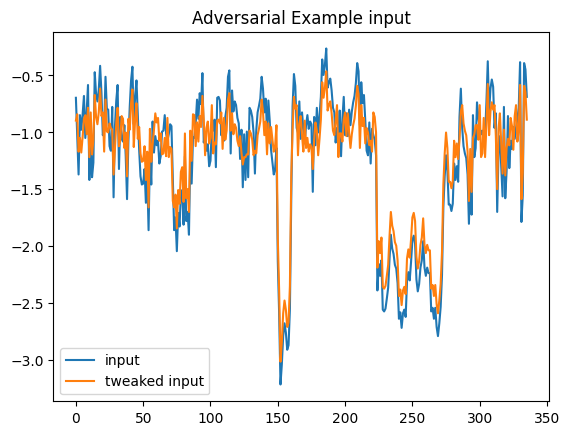

In [16]:
plt.plot(input_x[0, :, 0].cpu().numpy(), label='input')
plt.plot(tweaked_input_x[0, :, 0].cpu().detach().numpy(), label='tweaked input')
plt.title('Adversarial Example input')
plt.legend()
plt.show()